<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/classify_text_with_bert"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/classify_text_with_bert.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/classify_text_with_bert.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/classify_text_with_bert.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/collections/bert/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

# Analise de sentimento com em português com BERT

fine-tuning BERT para análise de sentimento no dataset de ecommerce brasileiro Olist.

## About BERT

[BERT](https://arxiv.org/abs/1810.04805) and other Transformer encoder architectures have been wildly successful on a variety of tasks in NLP (natural language processing). They compute vector-space representations of natural language that are suitable for use in deep learning models. The BERT family of models uses the Transformer encoder architecture to process each token of input text in the full context of all tokens before and after, hence the name: Bidirectional Encoder Representations from Transformers.

BERT models are usually pre-trained on a large corpus of text, then fine-tuned for specific tasks.


## Setup


In [1]:
%pip install transformers

In [2]:
import transformers
#
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#
from sklearn.metrics import confusion_matrix
import torch.nn.functional as F
from transformers import BertModel, BertTokenizer, get_linear_schedule_with_warmup
from torch.optim import AdamW  # agora direto do PyTorch
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from collections import defaultdict
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
print(torch.__version__)
print(torch.cuda.is_available())  # Deve ser False se for CPU-only

2.8.0+cu126
True


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Caminho para o arquivo CSV
csv_path = "olist_ecommerce_data.csv"

# Carregar o CSV em um DataFrame
df = pd.read_csv(csv_path)

# Exibir as primeiras linhas
df.head()

,Texto,review_score,Label
0,Recebi bem antes do prazo estipulado.,5,1
1,Parabéns lojas lannister adorei comprar pela I...,5,1
2,aparelho eficiente. no site a marca do aparelh...,4,1
3,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",4,1
4,"Vendedor confiável, produto ok e entrega antes...",5,1


In [7]:
# Carregando o tokenizador do modelo BERTIMBAU da hugging face.

PRE_TRAINED_MODEL_NAME = 'neuralmind/bert-base-portuguese-cased'

tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

In [8]:
# Testando a forma como o modelo tokeniza uma frase.

sample_txt = 'Quem conta um conto aumenta um ponto'

tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: Quem conta um conto aumenta um ponto
   Tokens: ['Quem', 'conta', 'um', 'conto', 'aumenta', 'um', 'ponto']
Token IDs: [15807, 1284, 222, 12059, 8101, 222, 2009]


In [9]:
''' A função encode_plus() do tokenizador do bertimbau prepara os dados para serem usados no modelo (máscara de atenção, padding, truncamento ...)
    Trata-se de um empacotador de texto para o bert que está retornando tensores pytorch dentro do dicionário encoding '''

encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=16, # Define o tamanho máximo da sequência de tokens, se o texto for maior ele é cortado, se for menor é preenchido com padding,
  # é preciso usar para garantir que todas as entradas do modelo tenham o mesmo tamanho
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  # tokens especiais para indicar o inicio e o fim da sequência de tokens
  return_token_type_ids=False,
  # Em tarefas de classificação simples não precisa deles
  padding='max_length',
  truncation=True, # se o texto ultrapassar max_length, ele corta para caber
  return_attention_mask=True,
  # array de 0s e 1s para dizer ao modelo quais tokens são reais e quais são padding
  return_tensors='pt',  # Return PyTorch tensors: As listas dentro do dicionário vão ser tensores pytorch
)
encoding.keys()

KeysView({'input_ids': tensor([[  101, 15807,  1284,   222, 12059,  8101,   222,  2009,   102,     0,
             0,     0,     0,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]])})

In [10]:
# Tensor pytorch input_ids gerado
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

16


tensor([  101, 15807,  1284,   222, 12059,  8101,   222,  2009,   102,     0,
            0,     0,     0,     0,     0,     0])

In [11]:
# Tensor pytorch input_ids decodificado
print(tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]))

['[CLS]', 'Quem', 'conta', 'um', 'conto', 'aumenta', 'um', 'ponto', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [12]:
''' Coleta a quantidade de tokens por texto para ajudar a definir o MAX_LEN
    512 é o tamanho máximo permitido pelo BERT base. Dessa forma vamos achar um tamanho ótimo
    considerando o dataset '''

token_lens = []

for txt in df.Texto:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


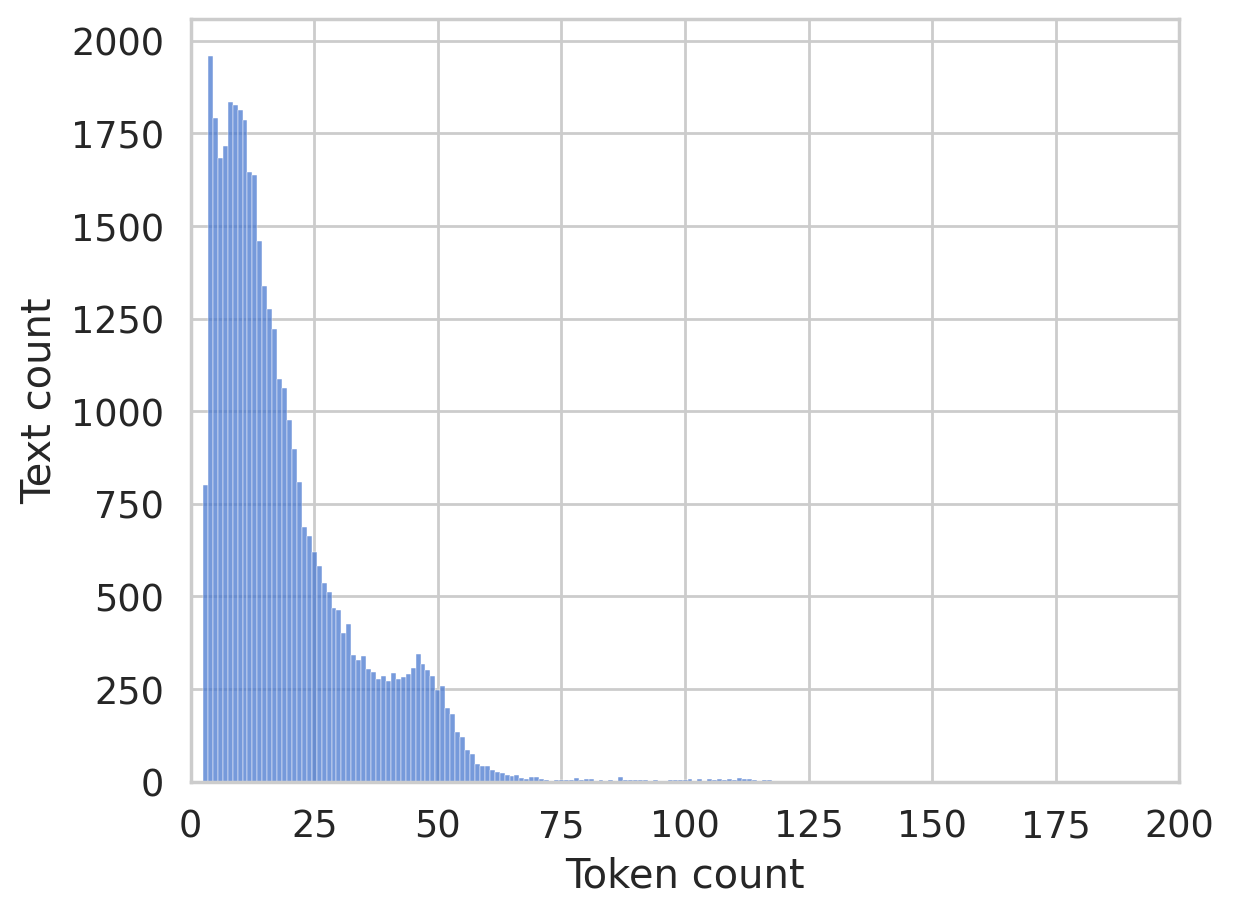

In [13]:
# Contagem de textos por comprimento (0–200 tokens)
sns.histplot(token_lens, bins=range(0, 201, 1), stat='count', kde=False, discrete=True)
plt.xlim(0, 200)
plt.xlabel('Token count')
plt.ylabel('Text count')
plt.tight_layout()

Let's try the preprocessing model on some text and see the output:

In [14]:
MAX_LEN = 128
''' Passar de 512 → 128 reduz custo para ~1/16 e costuma dar 8–16× mais throughput.

Memória (GPU/CPU): menos tokens ⇒ menos ativação/gradientes ⇒ muito menos risco de OOM.

Menos padding desperdiçado: se 90–95% dos textos têm <128 tokens, usar 512 enche o batch de zeros inúteis. '''

' Passar de 512 → 128 reduz custo para ~1/16 e costuma dar 8–16× mais throughput.\n\nMemória (GPU/CPU): menos tokens ⇒ menos ativação/gradientes ⇒ muito menos risco de OOM.\n\nMenos padding desperdiçado: se 90–95% dos textos têm <128 tokens, usar 512 enche o batch de zeros inúteis. '

In [15]:
''' Definição de seed aleatória para os geradores de números aleatórios do numpy e pytorch '''

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [16]:
# Essa parte define um dataset personalizado do pytorch. Ele usa o tokenizer para codificar cada texto e
# retorna os tensores input_ids, attention_mask, targets e mais os reviews para debugging se necessário.

class ReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews     # lista de reviews do Olist
    self.targets = targets     # Positivo ou Negativo (1, 0)
    self.tokenizer = tokenizer # tokenizador do bertimbau
    self.max_len = max_len     # 128

  def __len__(self):
    return len(self.reviews) # Tamanho da lista de reviews

  def __getitem__(self, item):
    review = str(self.reviews[item])  # Pega um review especifico
    target = self.targets[item]       # Pega um target especifico

    encoding = self.tokenizer.encode_plus( # Gera o dicionario encoding
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review, # Texto da review
      'input_ids': encoding['input_ids'].flatten(),           # flatten: [1, max_len] -> [max_len]
      'attention_mask': encoding['attention_mask'].flatten(), # flatten: [1, max_len] -> [max_len]
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [17]:
# Criando os datasets de treino, validação e teste
df, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED) # 90% para treino e validação e e 10% para teste
df_train, df_val = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED) # 80% de treino e 20% de validação

In [18]:
df_test.to_csv('/content/drive/MyDrive/df_test.csv', index=False)

In [19]:
df_train.shape, df_val.shape, df_test.shape

((29484, 3), (7371, 3), (4095, 3))

In [20]:
# Essa função usa a classe ReviewDataset e retorna um dataloader pytorch

def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = ReviewDataset(
    reviews=df.Texto.to_numpy(),
    targets=df.Label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4 # São 4 processos paralelos para preparar cada batch
  )

  # dataLoader é um garçom que leva os dados até o modelo em batches

In [21]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [22]:
len(train_data_loader)

1843

In [23]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [24]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16])


In [25]:
''' Cria um modelo com:

BERTimbau como base,

Camada Dropout,

Camada Linear para classificar em duas classes (positivo e negativo). '''

class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    ''' carregando o modelo Bertimbau pré-treinado
        então estamos baixando o modelo do hugging face com pesos já treinados
        return_dict = false -> Faz o modelo retornar os valores como tuple, não como dicionário
        self.drop = nn.Dropout(p=0.3) adiciona uma camada de dropout que desliga 30% dos neurônios durante o treinamento, isso ajuda a evitar overfitting
        p=0.3 significa que a chance de desligar um neurônio é de 30%
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        Adiciona uma camada linear, totalmente conectada, que transforma a saída do BERT em n_classes
        self.bert.config.hidden_size -> Geralmente é a dimensão de saída do BERT -> 768 '''

    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)
    self.drop = nn.Dropout(p=0.3)
    #The last_hidden_state is a sequence of hidden states of the last layer of the model
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    ''' Método que define como os dados passam pelas camadas, ou seja, a lógica de precisão do modelo
        1 -> Primeiro passamos os dados pelo modelo bert, que retorna last_hidden_state que é a representação de cada token, e o pooled_output que é um vetor
        que representa o sentido da frase inteira
        2-> Vamos usar o pooled_output que é a saída do token [CLS], como resumo do texto para classificar '''
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)


In [26]:
class_names = ['Negativo', 'Positivo']

model = SentimentClassifier(len(class_names))
model = model.to(device)


pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [27]:
''' AdamW: variante do Adam recomendada para Transformers.
    scheduler: ajusta o learning rate ao longo do tempo. '''

EPOCHS = 4

optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [28]:
# Treina o modelo por uma época e avalia no conjunto de validação

def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [29]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
# %%time

# history = defaultdict(list)
# best_accuracy = 0

# for epoch in range(EPOCHS):

#   print(f'Epoch {epoch + 1}/{EPOCHS}')
#   print('-' * 10)

#   train_acc, train_loss = train_epoch(
#     model,
#     train_data_loader,
#     loss_fn,
#     optimizer,
#     device,
#     scheduler,
#     len(df)
#   )

#   print(f'Train loss {train_loss} accuracy {train_acc}')

#   val_acc, val_loss = eval_model(
#     model,
#     val_data_loader,
#     loss_fn,
#     device,
#     len(df_val)
#   )

#   print(f'Val   loss {val_loss} accuracy {val_acc}')
#   print()

#   history['train_acc'].append(train_acc)
#   history['train_loss'].append(train_loss)
#   history['val_acc'].append(val_acc)
#   history['val_loss'].append(val_loss)

#   if val_acc > best_accuracy:
#     torch.save(model.state_dict(), 'best_model_state.bin')
#     best_accuracy = val_acc

In [ ]:
# %%time

# history = defaultdict(list)
# best_accuracy = 0
# # Definir seed e KFold
# seed = 42
# n_splits = 5
# kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)

# results = []

# for fold, (train_idx, val_idx) in enumerate(kf.split(df), 1):
#     print(f"\n===== FOLD {fold} =====")

#     # Dividir o DataFrame em treino e validação
#     df_train = df.iloc[train_idx]
#     df_val = df.iloc[val_idx]

#     # Criar DataLoaders
#     train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
#     val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)

#     # Instanciar modelo
#     model = SentimentClassifier(len(class_names))
#     model = model.to(device)

#     optimizer = AdamW(model.parameters(), lr=2e-5)
#     total_steps = len(train_data_loader) * EPOCHS
#     scheduler = get_linear_schedule_with_warmup(
#         optimizer,
#         num_warmup_steps=0,
#         num_training_steps=total_steps
#     )
#     loss_fn = nn.CrossEntropyLoss().to(device)

#     # Treinar
#     for epoch in range(EPOCHS):
#         train_acc, train_loss = train_epoch(
#             model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train)
#         )
#         val_acc, val_loss = eval_model(
#             model, val_data_loader, loss_fn, device, len(df_val)
#         )
#         print(f"Epoch {epoch+1}/{EPOCHS} - Train acc: {train_acc:.4f} Val acc: {val_acc:.4f} Train loss {train_loss:.4f} Val   loss {val_loss:.4f}")
#         if val_acc > best_accuracy:
#           torch.save(model.state_dict(), '/content/drive/MyDrive/best_bert_model_after_kfold.bin')
#           print(f"  ✓ Novo melhor modelo salvo! Accuracy: {val_acc:.4f}")
#           best_accuracy = val_acc

#     # Avaliação final
#     val_acc, _ = eval_model(model, val_data_loader, loss_fn, device, len(df_val))
#     results.append(val_acc)

# print(f"Resultados finais:", results)
# results = [acc.item() if torch.is_tensor(acc) else acc for acc in results]
# print(f"Média de Accuracy: {np.mean(results):.4f}")



In [ ]:
# results = [acc.item() if torch.is_tensor(acc) else acc for acc in results]
# print(f"Média de Accuracy: {np.mean(results):.4f}")

In [30]:
# from google.colab import drive
# drive.mount('/content/drive')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_names = ['Negativo', 'Positivo']

model = SentimentClassifier(len(class_names))
model.load_state_dict(torch.load('/content/drive/MyDrive/best_bert_model_after_kfold.bin'))
model = model.to(device)
model.eval()

SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, eleme

In [31]:
''' review_texts: textos de entrada

predictions: classes preditas

prediction_probs: probabilidades

real_values: rótulos reais '''

def get_predictions(model, data_loader):
  model = model.eval()

  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [32]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

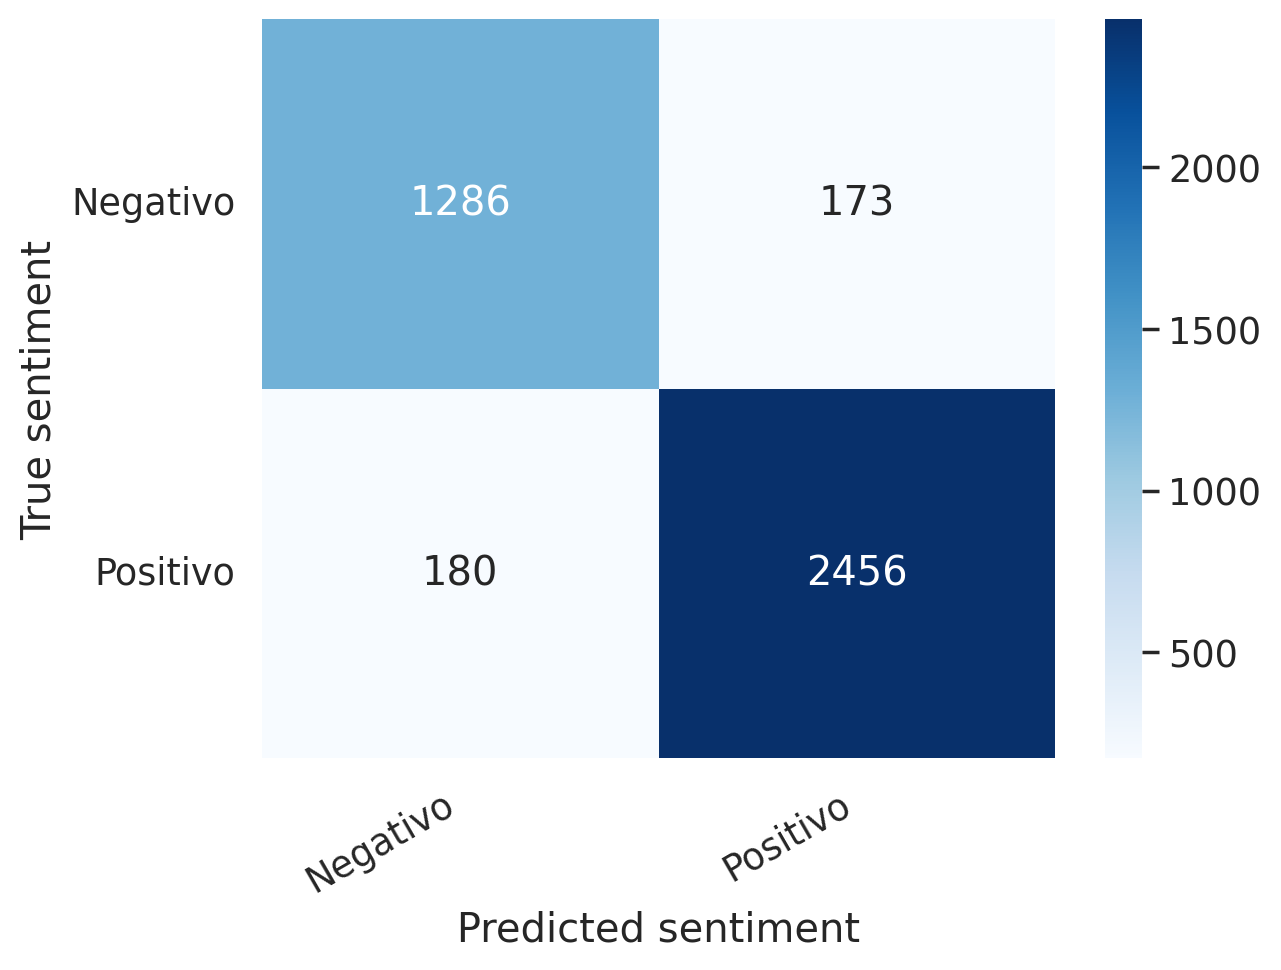

In [33]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [34]:
y_test = np.array(y_test)
y_pred = np.array(y_pred)

# Macro F1 Score
macro_f1_score = f1_score(y_test, y_pred, average='macro')
print("Macro F1 Score:", macro_f1_score)

# Macro Precision
macro_precision = precision_score(y_test, y_pred, average='macro')
print("Macro Precision:", macro_precision)

# Macro Recall
macro_recall = recall_score(y_test, y_pred, average='macro')
print("Macro Recall:", macro_recall)

Macro F1 Score: 0.9061348528015195
Macro Precision: 0.9057062141908621
Macro Recall: 0.9065701766337556


In [35]:
tests = ["Eu gostaria de fazer uma avaliação sincera aqui e ver se o modelo vai identificar. Mas esse é só um teste, \
          então nao consigo dizer se gosto ou nao gosto. Pode ser bom ou pode ser ruim :):(:",

        "Esse aplicativo é muito louco, bem complicado de mexer",

         "Na moral, tá pra nascer app melhor que o Zé delivery!. Bebida sempre gelada e em minutos."
         ]

In [36]:
''' Testando com frases manualmente '''
for test in tests:
  encoded_review = tokenizer.encode_plus(
    test,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt',
  )

  input_ids = encoded_review['input_ids'].to(device)
  attention_mask = encoded_review['attention_mask'].to(device)

  output = model(input_ids, attention_mask)
  _, prediction = torch.max(output, dim=1)
  probs = F.softmax(output, dim=1)

  print(f'Review text: {test}')
  print(pd.DataFrame(probs.tolist()[0], class_names)[0])
  print("========================\n")

Review text: Eu gostaria de fazer uma avaliação sincera aqui e ver se o modelo vai identificar. Mas esse é só um teste,           então nao consigo dizer se gosto ou nao gosto. Pode ser bom ou pode ser ruim :):(:
Negativo    0.613832
Positivo    0.386168
Name: 0, dtype: float64

Review text: Esse aplicativo é muito louco, bem complicado de mexer
Negativo    0.943311
Positivo    0.056689
Name: 0, dtype: float64

Review text: Na moral, tá pra nascer app melhor que o Zé delivery!. Bebida sempre gelada e em minutos.
Negativo    0.027873
Positivo    0.972127
Name: 0, dtype: float64



In [37]:
# Tarefa de férias

CSV_PATH = "/content/drive/MyDrive/feedbacks_revisados_arthur.csv"
df_analise_ferias = pd.read_csv(CSV_PATH)

In [38]:
colunas_unicas = sorted(df_analise_ferias["coluna_origem"].dropna().unique().tolist())
print("Qtd. de textos únicos em coluna_origem:", len(colunas_unicas))
for c in colunas_unicas:
    print("-", repr(c))

Qtd. de textos únicos em coluna_origem: 11
- 'Algum comentário para o programa de acolhimento em 2024.1?'
- 'Descreva como está sendo o  primeiro semestre na Universidade de Brasilia  (escreva no mínimo 250 caracteres e no máximo 500)'
- 'Descreva como foi esse primeiro semestre na Universidade de Brasilia  (escreva no mínimo 250 caracteres e no máximo 500)'
- 'Descreva o que você achou desta disciplina, você acha que devemos oferecer para os calouros no próximo semestre (escreva no mínimo 250 caracteres e no máximo 500)'
- 'Descreva o que você está achando desde modelo de ensino remoto (escreva no mínimo 250 caractérers e no máximo 500)'
- 'Gostaria de deixar alguma sugestão para a disciplina para o próximo semestre?'
- 'Gostaria de deixar alguma sugestão para o próximo Programa de Acolhiment@ d@s Calour@s no semestre 2021.1?'
- 'Gostaria de deixar alguma sugestão para o próximo Programa de Acolhiment@ d@s Calour@s no semestre 2022.2?'
- 'Gostaria de deixar alguma sugestão para o próx

In [39]:
COLUNAS_ORIGEM_PARA_REMOVER = [
    "Descreva como está sendo o  primeiro semestre na Universidade de Brasilia  (escreva no mínimo 250 caracteres e no máximo 500)",
    "Descreva como foi esse primeiro semestre na Universidade de Brasilia  (escreva no mínimo 250 caracteres e no máximo 500)",
    "Por que você escolhou o seu curso (escreva no mínimo 250 caracteres e no máximo 500)"
]

In [40]:
antes = len(df_analise_ferias)

df_filtrado = df_analise_ferias[
    ~df_analise_ferias["coluna_origem"].isin(COLUNAS_ORIGEM_PARA_REMOVER)
].copy()

depois = len(df_filtrado)

print(f"Linhas antes: {antes}")
print(f"Linhas depois: {depois}")
print(f"Linhas removidas: {antes - depois}")

Linhas antes: 669
Linhas depois: 380
Linhas removidas: 289


In [41]:
colunas_unicas = sorted(df_analise_ferias["curso"].dropna().unique().tolist())
print("Qtd. de textos únicos em coluna_origem:", len(colunas_unicas))
for c in colunas_unicas:
    print("-", repr(c))

Qtd. de textos únicos em coluna_origem: 4
- 'Ciência da Computação'
- 'Computação (Noturno)'
- 'Licenciatura em Computação'
- 'Licenciatura em Computação (noturno)'


In [42]:
# Curso permitido
CURSO_PERMITIDO = "Ciência da Computação"

antes = len(df_filtrado)

# Filtragem
df_filtrado_final = df_filtrado[df_filtrado["curso"] == CURSO_PERMITIDO].copy()

depois = len(df_filtrado_final)

print(f"Linhas antes: {antes}")
print(f"Linhas depois: {depois}")
print(f"Linhas removidas: {antes - depois}")

Linhas antes: 380
Linhas depois: 302
Linhas removidas: 78


In [43]:
# OUT_PATH = "/content/drive/MyDrive/feedbacks_final_final_sem_primeiro_semestre_e_motivo_curso_sem_licenciatura.csv"
# df_filtrado_final.to_csv(OUT_PATH, index=False)

In [44]:
df_filtrado_final.head(10)

,feedback,semestre,coluna_origem,acho_util,curso,sentimento
1,​Apesar de nada substituir o ensino presencial...,2021.2 - pandemia,Descreva o que você está achando desde modelo ...,SIM,Ciência da Computação,positivo
3,"Apesar dos pontos negativos do ensino remoto, ...",2021.2 - pandemia,Descreva o que você está achando desde modelo ...,SIM,Ciência da Computação,positivo
4,O modelo de ensino remoto oferece diversas van...,2021.2 - pandemia,Descreva o que você está achando desde modelo ...,SIM,Ciência da Computação,negativo
5,"Como dito anteriormente, o modelo de ensino re...",2021.2 - pandemia,Descreva o que você está achando desde modelo ...,SIM,Ciência da Computação,positivo
6,Gosto da fácil acessibilidade e contato que o ...,2021.2 - pandemia,Descreva o que você está achando desde modelo ...,SIM,Ciência da Computação,positivo
9,"Algumas coisas ,como as monitorias on-line, ca...",2021.2 - pandemia,Descreva o que você está achando desde modelo ...,SIM,Ciência da Computação,negativo
10,não acho que eu consiga me acostumar com ensin...,2021.2 - pandemia,Descreva o que você está achando desde modelo ...,SIM,Ciência da Computação,negativo
11,"Bem complicado, com suas vantagens e desvantag...",2021.2 - pandemia,Descreva o que você está achando desde modelo ...,SIM,Ciência da Computação,negativo
12,Acho que é um bom modelo. Consegui acompanhar ...,2021.2 - pandemia,Descreva o que você está achando desde modelo ...,SIM,Ciência da Computação,positivo
13,Acho que o modelo de ensino remoto está funcio...,2021.2 - pandemia,Descreva o que você está achando desde modelo ...,SIM,Ciência da Computação,positivo


In [ ]:
# 1) Carregar base rotulada manualmente (248 linhas)
# csv_analise_manual = "feedbacks_alunos_com_sentimento - analise manual.csv"
# df_analise_manual = pd.read_csv(csv_analise_manual)
# df_analise_manual.head()

,feedback,sentimento
0,Não sei como que os veteranos sobreviveram sem...,positivo
1,"Foi um bom semestre, passou rápido, as coisas ...",positivo
2,Uma disciplina que eu gostaria de ter tido enq...,positivo
3,Um pouco decepcionante por não poder ter essa ...,negativo
4,Essa é a segunda vez que eu inicio um curso na...,positivo


In [ ]:
# COL_TEXTO = "feedback"   # <-- mude se necessário
# COL_MANUAL = "sentimento"  # coluna com rótulo manual

In [ ]:
# # 2) Padronizar rótulo manual para 0/1
# # Se já for numérico 0/1, ok. Se for 'positivo'/'negativo', converte.
# if df_analise_manual[COL_MANUAL].dtype == object:
#     mapa = {"negativo": 0, "positivo": 1, "Negativo": 0, "Positivo": 1}
#     df_analise_manual[COL_MANUAL] = df_analise_manual[COL_MANUAL].map(mapa)

In [ ]:
# df_analise_manual = df_analise_manual.dropna(subset=[COL_TEXTO, COL_MANUAL]).copy()
# df_analise_manual[COL_MANUAL] = df_analise_manual[COL_MANUAL].astype(int)

In [ ]:
# y_manual = df_analise_manual[COL_MANUAL].to_numpy()

In [ ]:
# 3) Função para predizer classe (0/1) para uma lista de textos
# def predict_texts(model, tokenizer, texts, max_len=128, device="cpu", batch_size=32):
#     model.eval()
#     preds_all = []

#     with torch.no_grad():
#         for i in range(0, len(texts), batch_size):
#             batch_texts = texts[i:i+batch_size]

#             enc = tokenizer(
#                 batch_texts,
#                 max_length=max_len,
#                 padding="max_length",
#                 truncation=True,
#                 return_tensors="pt"
#             )

#             input_ids = enc["input_ids"].to(device)
#             attention_mask = enc["attention_mask"].to(device)

#             outputs = model(input_ids=input_ids, attention_mask=attention_mask)  # logits [B,2]
#             preds = torch.argmax(outputs, dim=1)  # [B]
#             preds_all.extend(preds.cpu().numpy().tolist())

#     return np.array(preds_all, dtype=int)

In [ ]:
# texts_manual = df_analise_manual[COL_TEXTO].astype(str).tolist()
# y_pred_manual = predict_texts(model, tokenizer, texts_manual, max_len=MAX_LEN, device=device, batch_size=32)

# # 5) Checagem de alinhamento
# print("len(y_manual):", len(y_manual))
# print("len(y_pred_manual):", len(y_pred_manual))

len(y_manual): 248
len(y_pred_manual): 248


In [ ]:
# macro_precision = precision_score(y_manual, y_pred_manual, average='macro', zero_division=0)
# macro_recall    = recall_score(y_manual, y_pred_manual, average='macro', zero_division=0)
# macro_f1        = f1_score(y_manual, y_pred_manual, average='macro', zero_division=0)
# accuracy        = accuracy_score(y_manual, y_pred_manual)

In [ ]:
# print(f"Macro Precision: {macro_precision:.2%}")
# print(f"Macro Recall:    {macro_recall:.2%}")
# print(f"Macro F1-Score:  {macro_f1:.2%}")
# print(f"Accuracy:        {accuracy:.2%}")

Macro Precision: 79.28%
Macro Recall:    81.34%
Macro F1-Score:  80.21%
Accuracy:        85.48%


In [ ]:
# df_analise_manual["sentimento_predito"] = y_pred_manual
# df_analise_manual.to_csv("analise_manual_com_predicao.csv", index=False)

In [ ]:
# # Caminho para o arquivo CSV
# csv_path_respostas_unificadas = "feedbacks_alunos.csv"

# # Carregar o CSV em um DataFrame
# df_respostas_unificadas = pd.read_csv(csv_path_respostas_unificadas)

# # Exibir as primeiras linhas
# print(len(df_respostas_unificadas))

In [ ]:
df_filtrado_final.columns

# df_respostas_unificadas = df_filtrado_final.dropna(subset=['feedback'])  # remove NaN
# df_respostas_unificadas = df_respostas_unificadas[df_respostas_unificadas['feedback'].str.strip() != '']  # remove strings vazias ou só espaços

# df_respostas_unificadas.to_csv("feedbacks_alunos_preprocessado.csv", index=False)


Index(['feedback', 'semestre', 'coluna_origem', 'acho_util', 'curso',
       'sentimento'],
      dtype='object')

In [ ]:
# sentimentos = []  # lista para guardar os sentimentos

# texto_feedbacks = df_filtrado_final['feedback'].to_list()

# for feedback in texto_feedbacks:
#     # Tokenização do feedback
#     encoded_review = tokenizer.encode_plus(
#         feedback,
#         max_length=MAX_LEN,
#         add_special_tokens=True,
#         return_token_type_ids=False,
#         padding='max_length',
#         truncation=True,
#         return_attention_mask=True,
#         return_tensors='pt',
#     )

#     input_ids = encoded_review['input_ids'].to(device)
#     attention_mask = encoded_review['attention_mask'].to(device)

#     # Geração da predição
#     output = model(input_ids, attention_mask)
#     _, prediction = torch.max(output, dim=1)

#     # Converter para rótulo de sentimento
#     label = 'positivo' if prediction.item() == 1 else 'negativo'
#     sentimentos.append(label)

# # Adiciona a nova coluna ao DataFrame
# df_filtrado_final['sentimento'] = sentimentos

# df_filtrado_final.head()

In [ ]:
# if "tab" in df_respostas_unificadas.columns:
#     df_respostas_unificadas = df_respostas_unificadas.rename(columns={"tab": "semestre"})

# # Salvar em CSV (opcional)
# df_respostas_unificadas.to_csv("feedbacks_alunos_com_sentimento.csv", index=False)

In [ ]:
# df_respostas_com_sentimento = pd.read_csv("feedbacks_alunos_com_sentimento.csv")
# df_respostas_com_sentimento.head()

In [ ]:
# Dicionario para converter tab da planilha em semestre
# dicionario_semestres = {
#     'analise_ensino_remoto': '2021.2 - pandemia',
#     'avaliacao_da_disciplina': '2021.2 - pandemia',
#     'analise_primeiro_semestre': '2021.2 - pandemia',
#     'Licenciatura': '2021.2 - pandemia',
#     'Avaliação da Disciplina 20221': '2022.1 - presencial'
#     }

# Aplicar substituição no DataFrame
# df_respostas_com_sentimento["tab"] = df_respostas_com_sentimento["tab"].replace(dicionario_semestres)
# df_respostas_com_sentimento.rename(columns={"tab": "semestre"}, inplace=True)

In [ ]:
# Análise 1: Sentimentos por curso (foco nos dois principais)
dados_analise1 = df_filtrado_final.groupby(["curso", "sentimento"]).size().reset_index(name="quantidade")

# # Análise 2: Sentimentos por semestre
df_semestre = df_filtrado_final.dropna(subset=["semestre"])
dados_analise2 = df_semestre.groupby(["semestre", "sentimento"]).size().reset_index(name="quantidade")

# # Análise 3: Sentimento vs percepção de utilidade
df_util = df_filtrado_final[df_filtrado_final["acho_util"].isin(["SIM", "UM POUCO"])]
dados_analise3 = df_util.groupby(["acho_util", "sentimento"]).size().reset_index(name="quantidade")

# # Análise 4: Sentimento por curso e semestre
dados_analise4 = df_filtrado_final.groupby(["curso", "semestre", "sentimento"]).size().reset_index(name="quantidade")

# Análise 5: Seleção aleatória de amostras para comparação manual x automática
# (mudar n para ter mais exemplos)
amostras_analise5 = df_filtrado_final[["feedback", "sentimento"]].sample(n=10, random_state=42)

In [ ]:
dados_analise4.head(15)

,curso,semestre,sentimento,quantidade
0,Ciência da Computação,2021.2 - pandemia,negativo,17
1,Ciência da Computação,2021.2 - pandemia,positivo,59
2,Ciência da Computação,2022.1 - presencial,negativo,13
3,Ciência da Computação,2022.1 - presencial,positivo,42
4,Ciência da Computação,2023.1 presencial,negativo,5
5,Ciência da Computação,2023.1 presencial,positivo,42
6,Ciência da Computação,2023.2 presencial,negativo,7
7,Ciência da Computação,2023.2 presencial,positivo,45
8,Ciência da Computação,2024.1 presencial,negativo,7
9,Ciência da Computação,2024.1 presencial,positivo,48


In [ ]:
# Calcular total por curso para obter porcentagem
dados_analise1["total"] = dados_analise1.groupby("curso")["quantidade"].transform("sum")
dados_analise1["porcentagem"] = (dados_analise1["quantidade"] / dados_analise1["total"]) * 100

dados_analise2["total"] = dados_analise2.groupby("semestre")["quantidade"].transform("sum")
dados_analise2["porcentagem"] = (dados_analise2["quantidade"] / dados_analise2["total"]) * 100

dados_analise3["total"] = dados_analise3.groupby("acho_util")["quantidade"].transform("sum")
dados_analise3["porcentagem"] = (dados_analise3["quantidade"] / dados_analise3["total"]) * 100

dados_analise4["total"] = dados_analise4.groupby(["curso","semestre"])["quantidade"].transform("sum")
dados_analise4["porcentagem"] = (dados_analise4["quantidade"] / dados_analise4["total"]) * 100



# print(dados_analise1["porcentagem"])
dados_analise4.head(10)
# print(dados_analise1["total"].iloc[0])

,curso,semestre,sentimento,quantidade,total,porcentagem
0,Ciência da Computação,2021.2 - pandemia,negativo,17,76,22.368421
1,Ciência da Computação,2021.2 - pandemia,positivo,59,76,77.631579
2,Ciência da Computação,2022.1 - presencial,negativo,13,55,23.636364
3,Ciência da Computação,2022.1 - presencial,positivo,42,55,76.363636
4,Ciência da Computação,2023.1 presencial,negativo,5,47,10.638298
5,Ciência da Computação,2023.1 presencial,positivo,42,47,89.361702
6,Ciência da Computação,2023.2 presencial,negativo,7,52,13.461538
7,Ciência da Computação,2023.2 presencial,positivo,45,52,86.538462
8,Ciência da Computação,2024.1 presencial,negativo,7,55,12.727273
9,Ciência da Computação,2024.1 presencial,positivo,48,55,87.272727


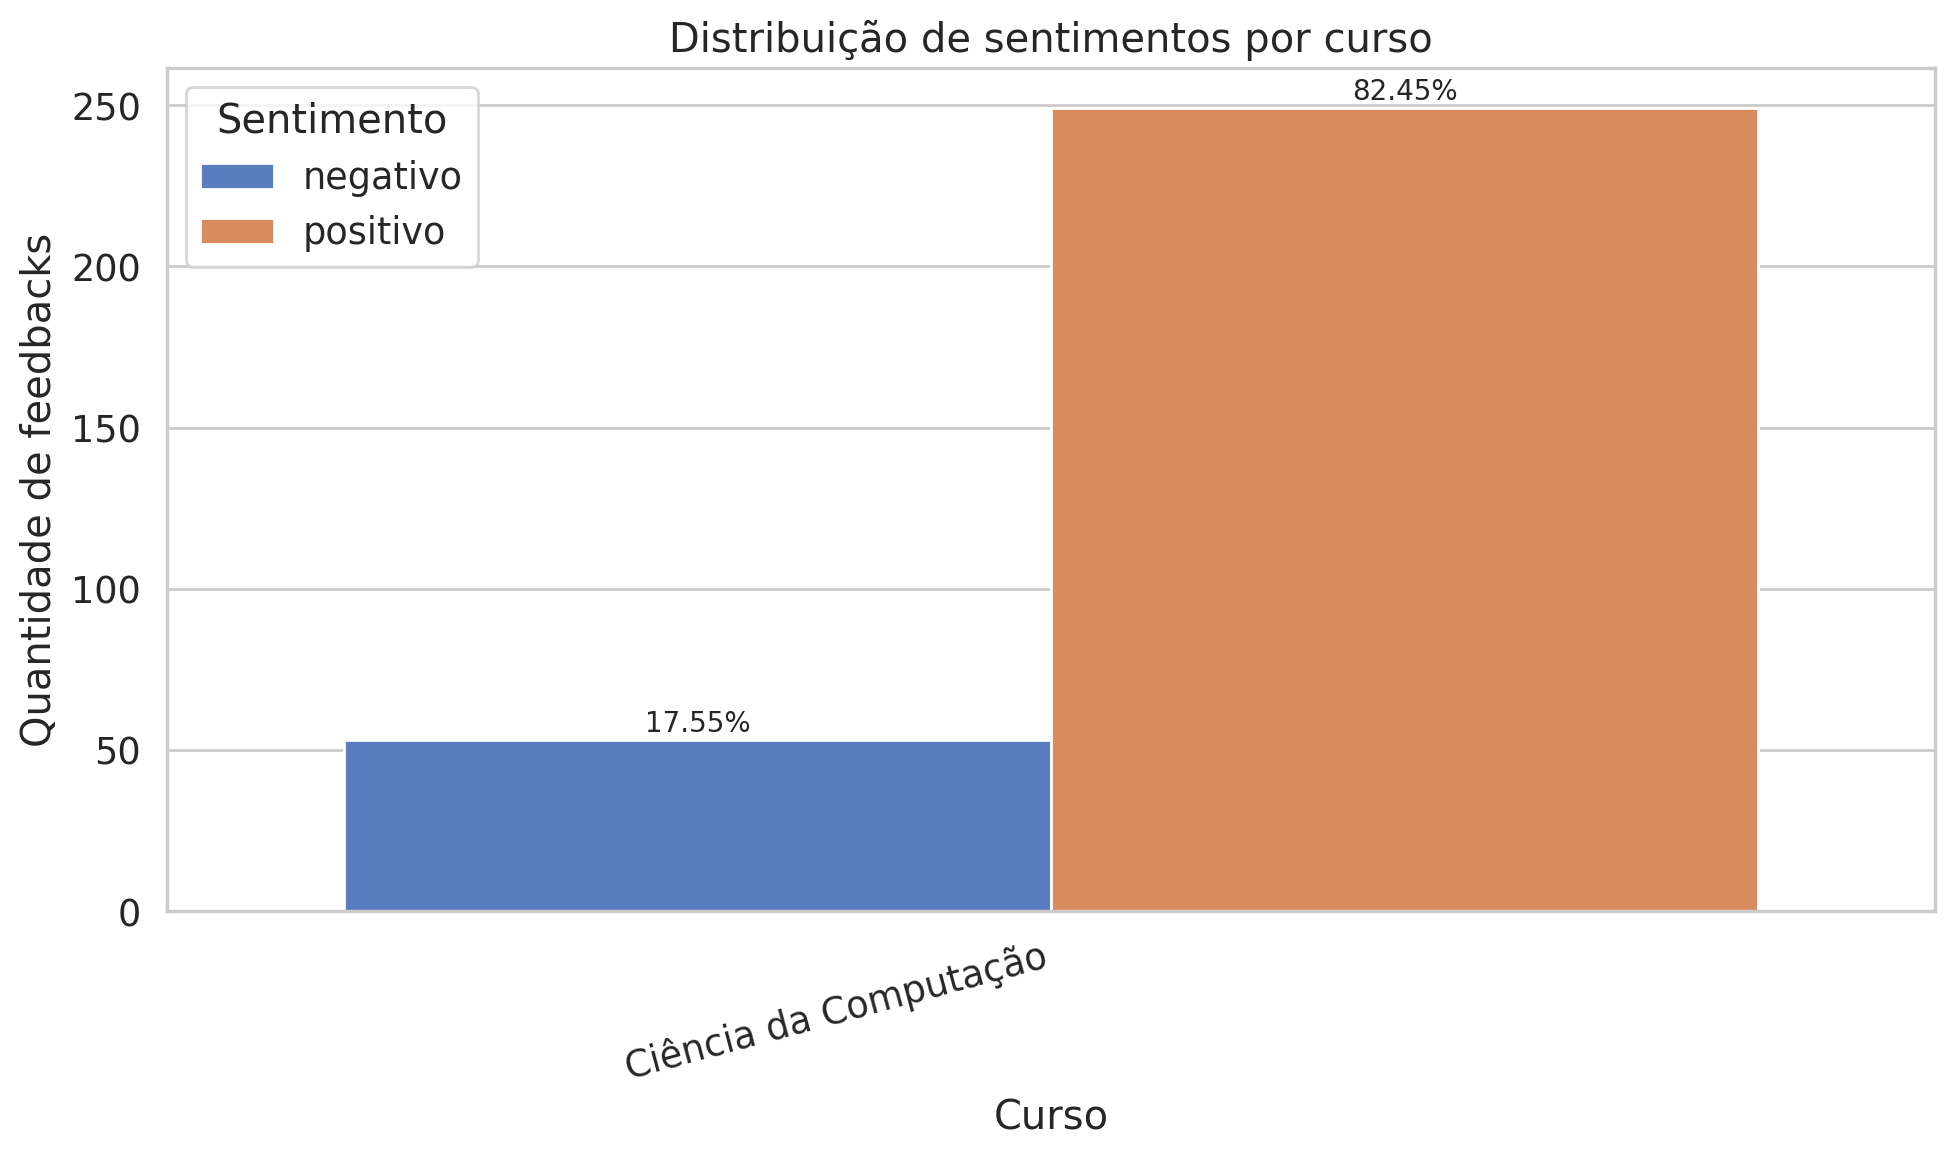

In [ ]:
# Criando gráfico de sentimento por curso
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=dados_analise1, x="curso", y="quantidade", hue="sentimento")
dados_analise1.sort_values(by="sentimento", inplace=True)
count = 0
for patch in ax.patches:
    if(count == len(dados_analise1)):
      break
    else:
      altura = patch.get_height()
      porcentagem = dados_analise1["porcentagem"].iloc[count]

      ax.text(patch.get_x() + patch.get_width() / 2, altura + 1,  # Posição do texto
          f'{porcentagem:.2f}%',  # Formatação do percentual
          ha='center', va='bottom', fontsize=10)
      count += 1

# Título e rótulos
plt.title("Distribuição de sentimentos por curso")
plt.xlabel("Curso")
plt.ylabel("Quantidade de feedbacks")
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.legend(title="Sentimento")
plt.show()

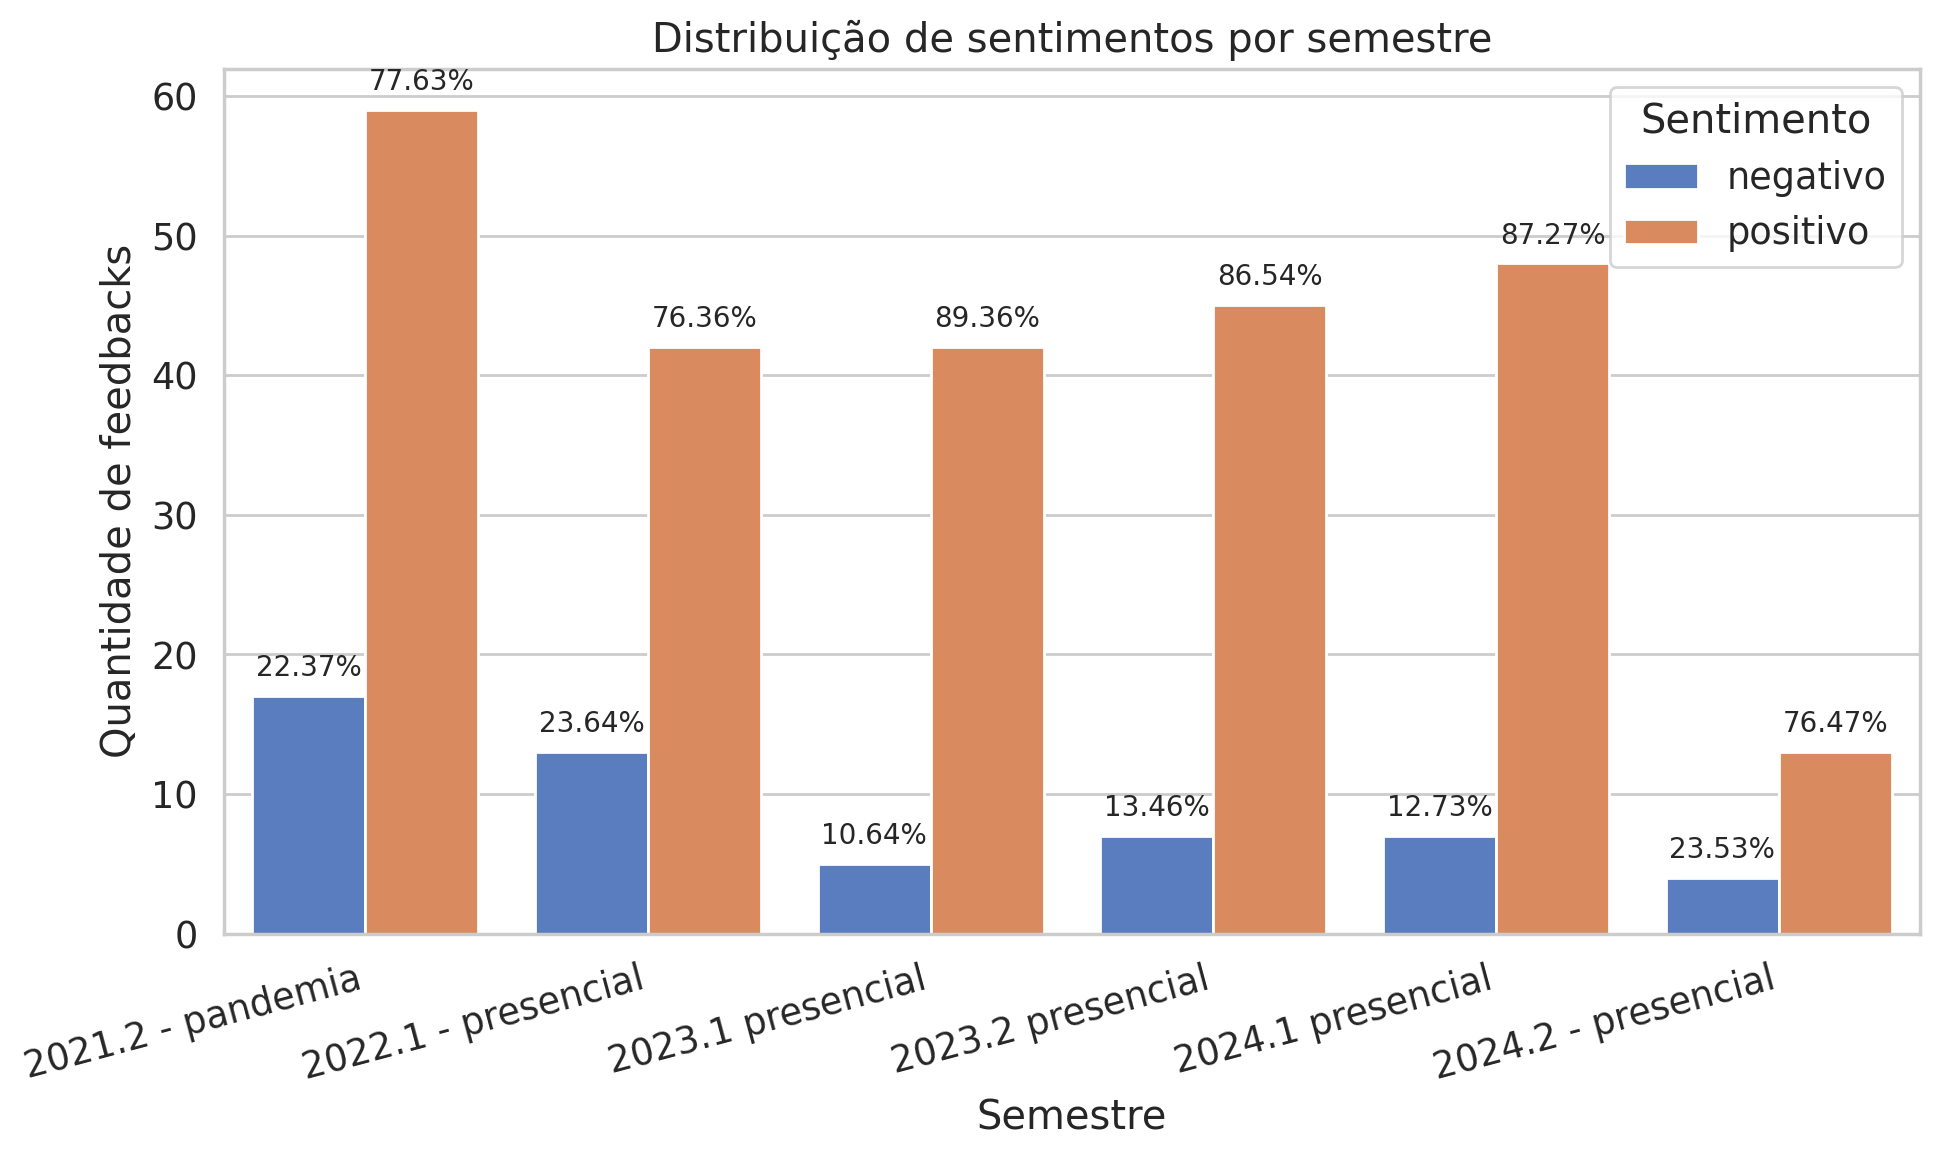

In [ ]:
# Criando gráfico de sentimento por semestre
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=dados_analise2, x="semestre", y="quantidade", hue="sentimento")
dados_analise2.sort_values(by="sentimento", inplace=True)
count = 0
for patch in ax.patches:
    if(count == len(dados_analise2)):
      break
    else:
      altura = patch.get_height()
      porcentagem = dados_analise2["porcentagem"].iloc[count]

      ax.text(patch.get_x() + patch.get_width() / 2, altura + 1,  # Posição do texto
          f'{porcentagem:.2f}%',  # Formatação do percentual
          ha='center', va='bottom', fontsize=10)
      count += 1

# Título e rótulos
plt.title("Distribuição de sentimentos por semestre")
plt.xlabel("Semestre")
plt.ylabel("Quantidade de feedbacks")
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.legend(title="Sentimento")
plt.show()

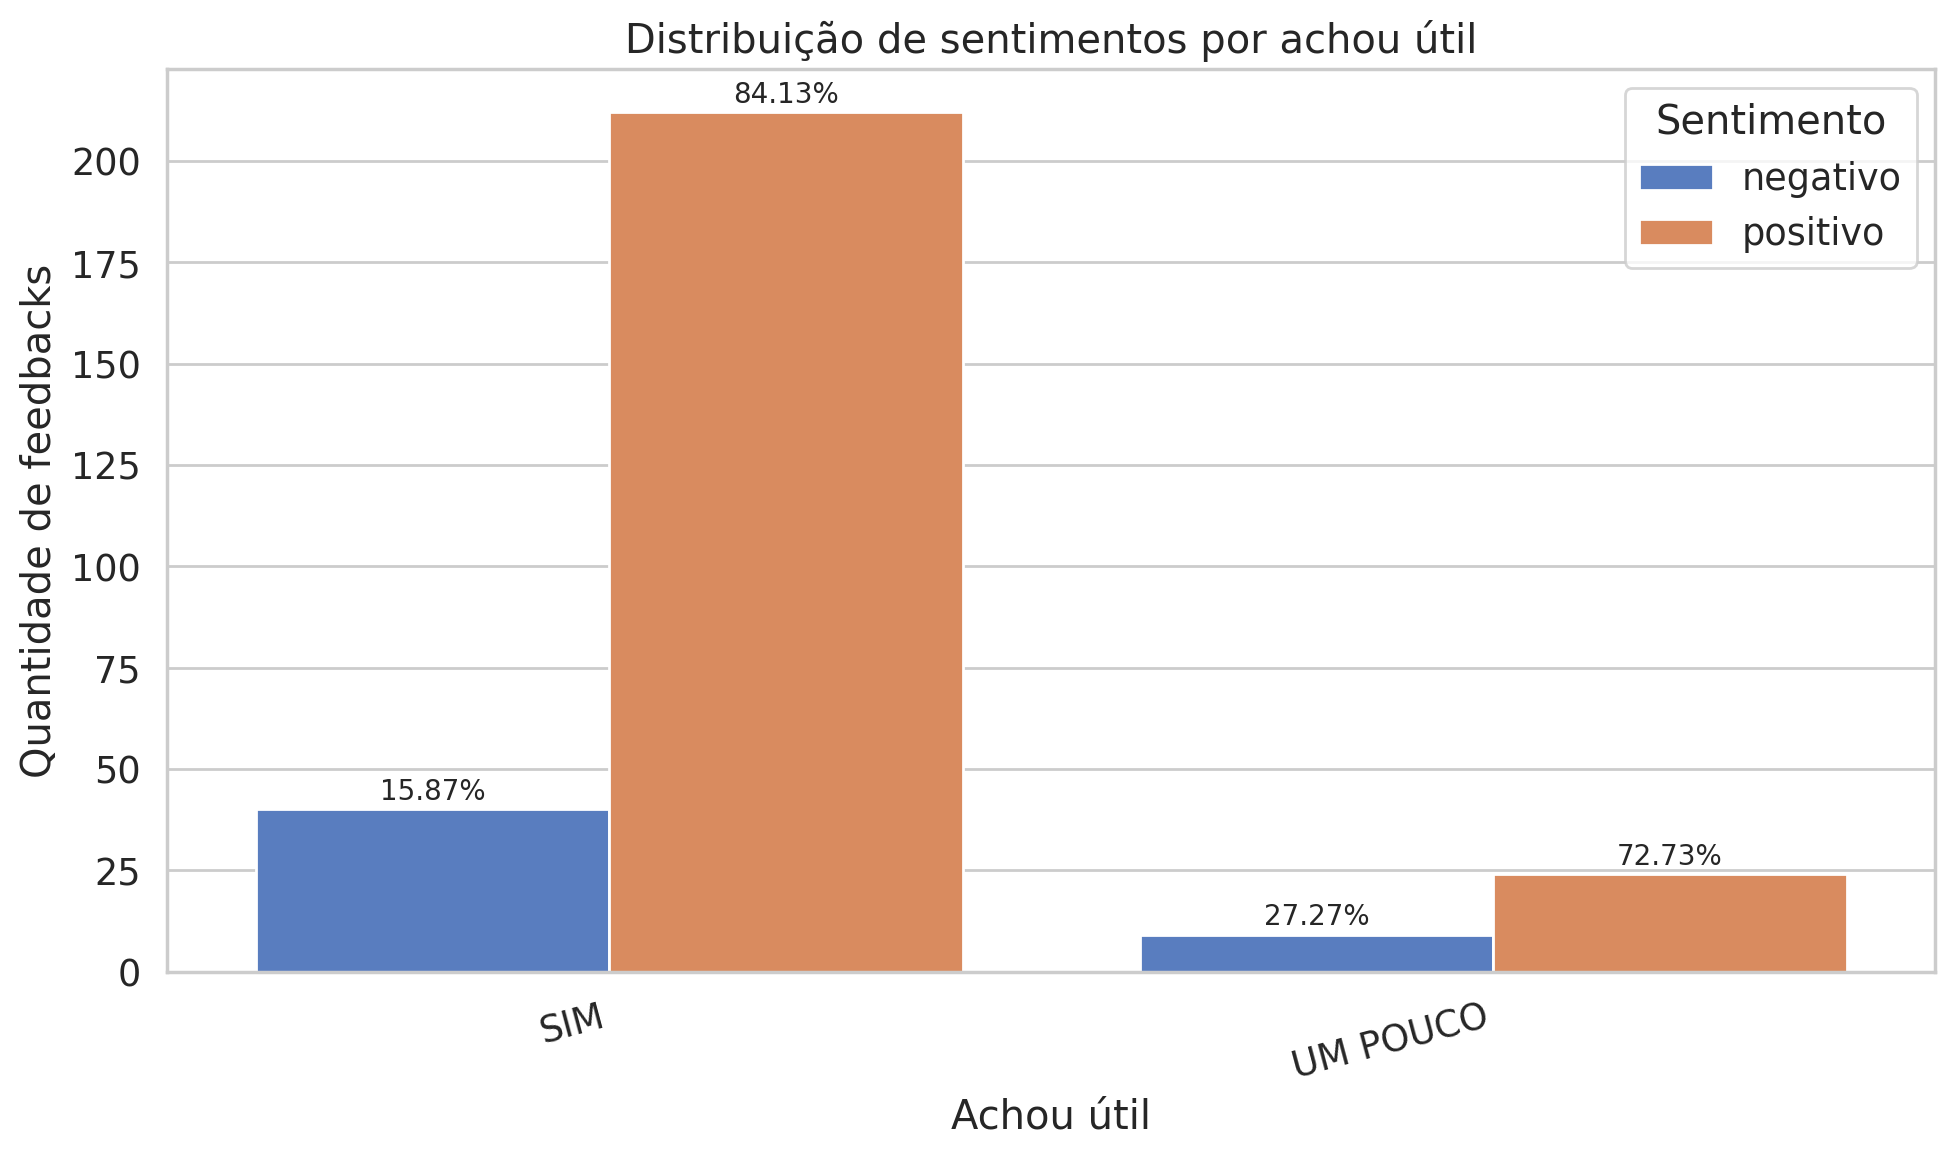

In [ ]:
# Criando gráfico de sentimento por achou útil
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=dados_analise3, x="acho_util", y="quantidade", hue="sentimento")
dados_analise3.sort_values(by="sentimento", inplace=True)
count = 0
for patch in ax.patches:
    if(count == len(dados_analise3)):
      break
    else:
      altura = patch.get_height()
      porcentagem = dados_analise3["porcentagem"].iloc[count]

      ax.text(patch.get_x() + patch.get_width() / 2, altura + 1,  # Posição do texto
          f'{porcentagem:.2f}%',  # Formatação do percentual
          ha='center', va='bottom', fontsize=10)
      count += 1

# Título e rótulos
plt.title("Distribuição de sentimentos por achou útil")
plt.xlabel("Achou útil")
plt.ylabel("Quantidade de feedbacks")
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.legend(title="Sentimento")
plt.show()

/tmp/ipython-input-2449679466.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=15, ha='right')


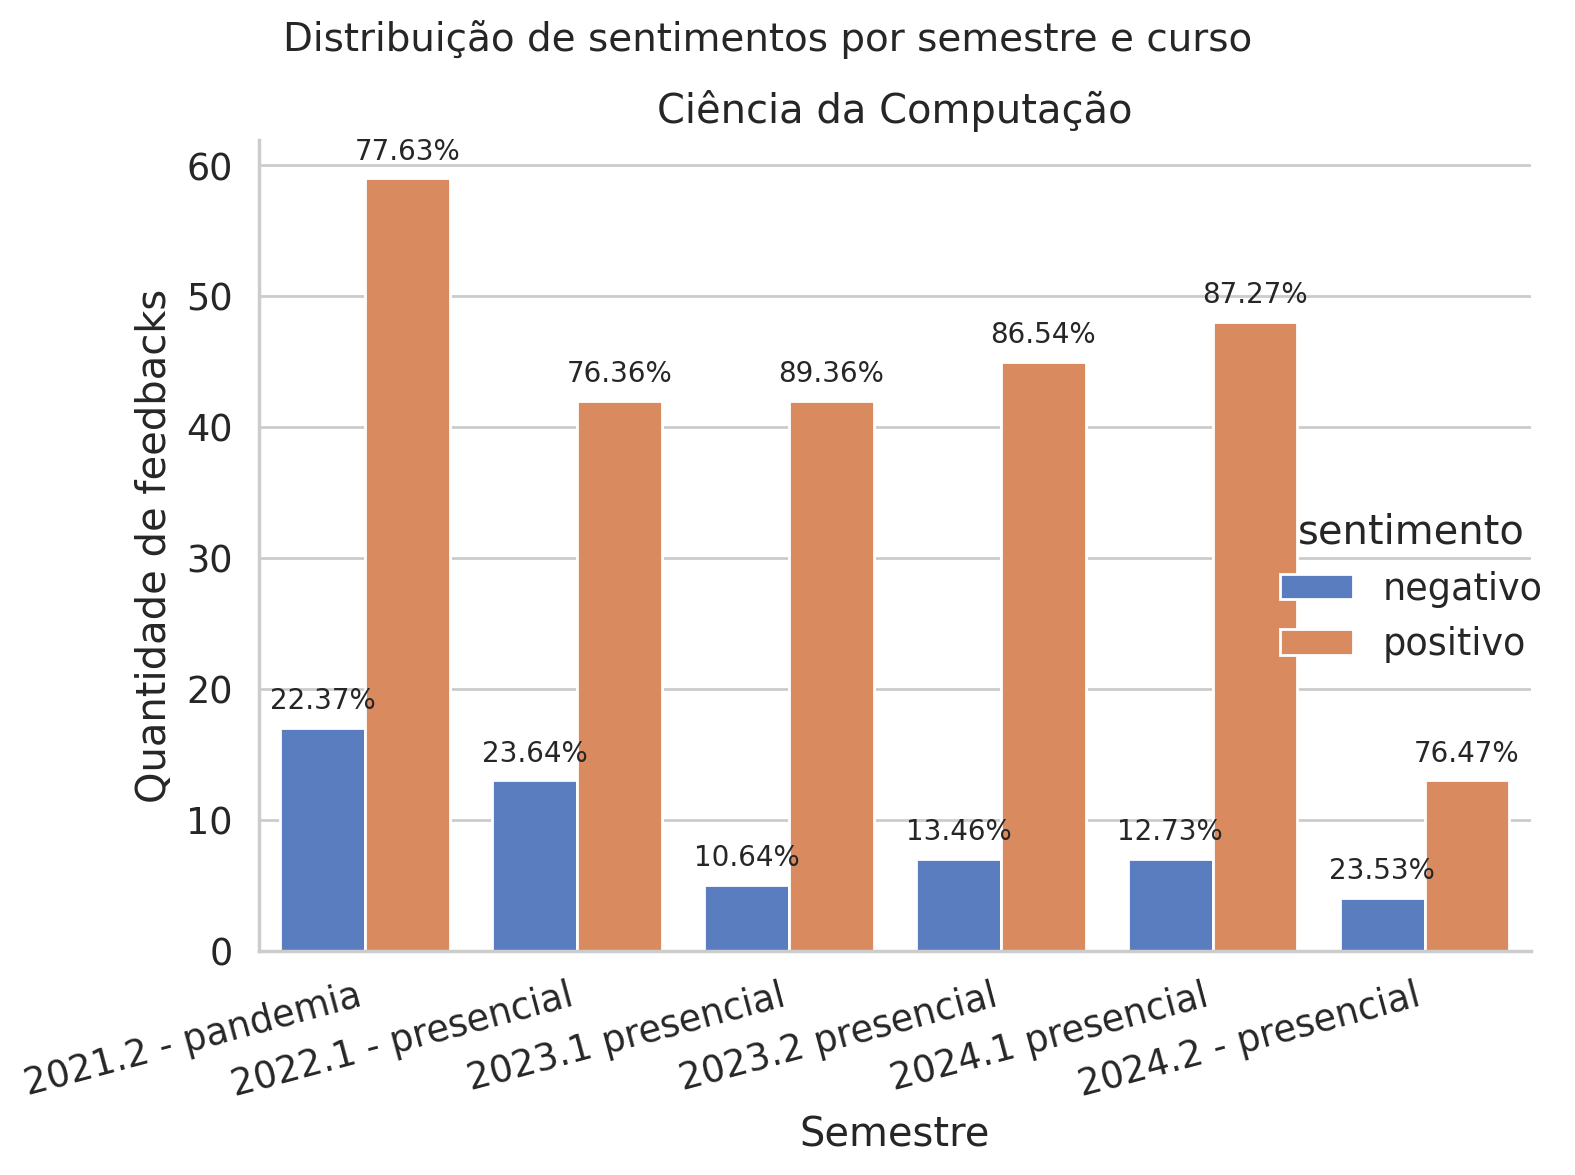

In [ ]:
# Garante ordenação consistente
dados_analise4 = dados_analise4.sort_values("sentimento").reset_index(drop=True)

# Gráfico de barras separado por curso
g = sns.catplot(
    data=dados_analise4,
    x="semestre", y="quantidade", hue="sentimento",
    col="curso",
    kind="bar",
    height=6, aspect=1.1
)

# Adiciona porcentagens nas barras
for ax, (curso, grupo_curso) in zip(g.axes.flat, dados_analise4.groupby("curso")):
    grupo_curso = grupo_curso.reset_index(drop=True)

    for patch, (_, row) in zip(ax.patches, grupo_curso.iterrows()):
        altura = patch.get_height()
        x = patch.get_x() + patch.get_width() / 2
        porcentagem = row["porcentagem"]

        ax.text(x, altura + 1, f'{porcentagem:.2f}%', ha='center', va='bottom', fontsize=10)

# Ajustes visuais
g.set_titles("{col_name}")
g.set_axis_labels("Semestre", "Quantidade de feedbacks")
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=15, ha='right')

g.fig.suptitle("Distribuição de sentimentos por semestre e curso", fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

In [ ]:
df_filtrado_final.head(10)

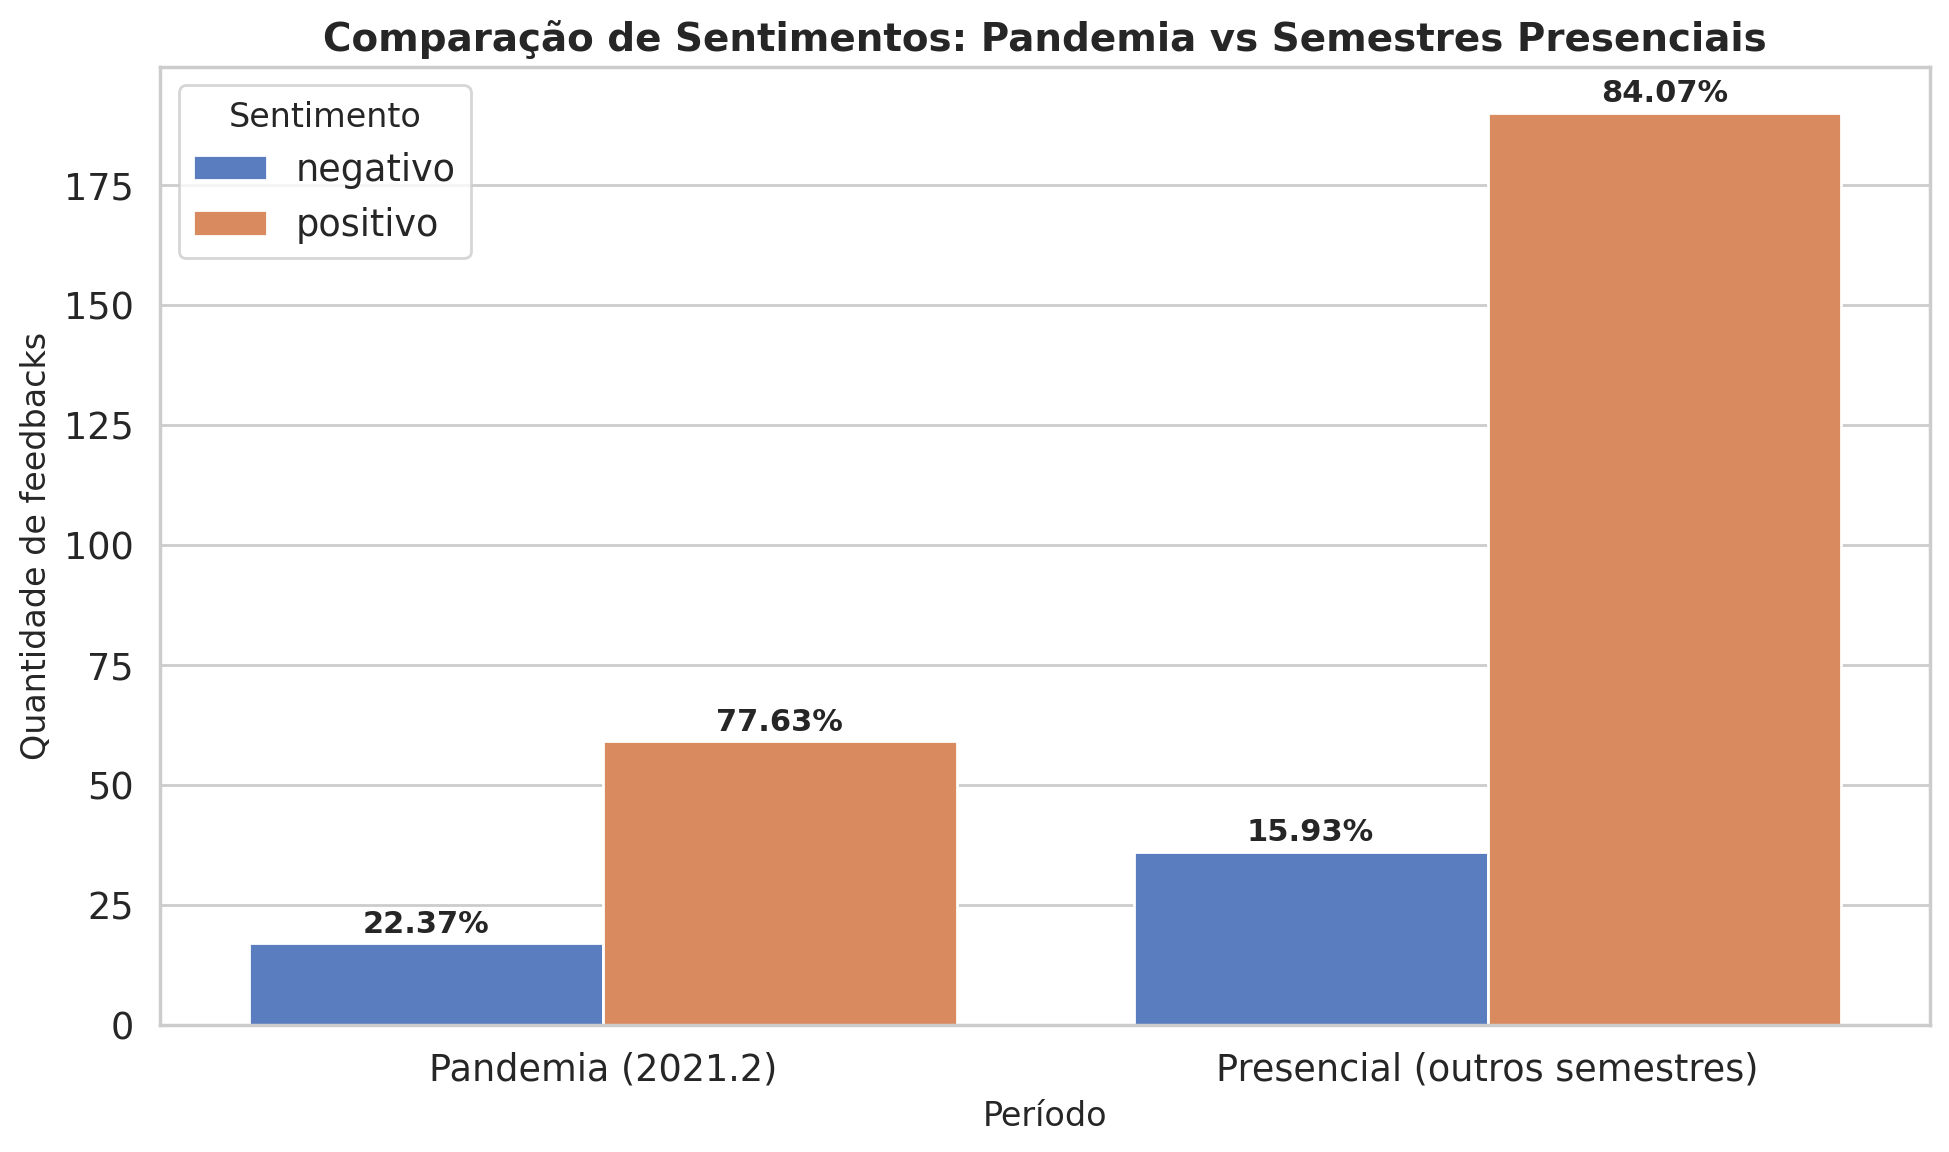

In [45]:
# Criando coluna de período (Pandemia vs Presencial)
df_filtrado_final['periodo'] = df_filtrado_final['semestre'].apply(
    lambda x: 'Pandemia (2021.2)' if x == '2021.2 - pandemia' else 'Presencial (outros semestres)'
)

# Preparando dados para o gráfico
dados_comparacao = df_filtrado_final.groupby(['periodo', 'sentimento']).size().reset_index(name='quantidade')

# Calculando porcentagens
dados_comparacao['total'] = dados_comparacao.groupby('periodo')['quantidade'].transform('sum')
dados_comparacao['porcentagem'] = (dados_comparacao['quantidade'] / dados_comparacao['total']) * 100

# Criando o gráfico
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=dados_comparacao, x='periodo', y='quantidade', hue='sentimento')

# Adiciona porcentagens nas barras
dados_comparacao_sorted = dados_comparacao.sort_values('sentimento').reset_index(drop=True)
count = 0
for patch in ax.patches:
    if count < len(dados_comparacao_sorted):
        altura = patch.get_height()
        porcentagem = dados_comparacao_sorted['porcentagem'].iloc[count]

        ax.text(patch.get_x() + patch.get_width() / 2, altura + 1,
               f'{porcentagem:.2f}%',
               ha='center', va='bottom', fontsize=11, fontweight='bold')
        count += 1

# Ajustes visuais
plt.title('Comparação de Sentimentos: Pandemia vs Semestres Presenciais', fontsize=14, fontweight='bold')
plt.xlabel('Período', fontsize=12)
plt.ylabel('Quantidade de feedbacks', fontsize=12)
plt.legend(title='Sentimento', title_fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
!pip freeze > requirements.txt